In [ ]:
# STEP 1: Import Libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# STEP 2: Load Dataset and Organize
dataset_path = '/content/drive/MyDrive/facial_dataset'

folder_names = []
folder_paths = []

for root, folders, files in os.walk(dataset_path):
    folder_names.extend(folders)
    folder_paths.extend([os.path.join(dataset_path, f) for f in folders])
    break  # only get top-level folders


In [ ]:
# Collect image info
person_data = []
for label_index, folder in enumerate(folder_paths):
    for file in os.listdir(folder):
        if file.endswith(('.jpg', '.png')):
            person_data.append({
                'path': os.path.join(folder, file),
                'label': label_index,
                'name': folder_names[label_index]
            })

In [ ]:
# Shuffle data
random.shuffle(person_data)

# STEP 3: Split Train and Test
test_size = int(len(person_data) * 0.15)
test_data = person_data[:test_size]
train_data = person_data[test_size:]


In [ ]:
# STEP 4: Preprocess Images
def load_images(data_list, img_shape=(227, 227)):
    images = []
    labels = []
    for item in data_list:
        img = cv2.imread(item['path'])
        img = cv2.resize(img, img_shape)
        if img is not None:
            images.append(img)
            labels.append(item['label'])
    return np.array(images), np.array(labels).reshape(-1, 1)

X_train, Y_train = load_images(train_data)
X_test, Y_test = load_images(test_data)

In [ ]:
# STEP 5: Normalize Images
train_mean = np.mean(X_train, axis=0)
test_mean = np.mean(X_test, axis=0)
X_train_norm = X_train - train_mean
X_test_norm = X_test - test_mean

In [ ]:
# STEP 6: Define Custom CNN Model
model = Sequential([
    Input(shape=(227, 227, 3)),
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,827,076 (10.78 MB)

 Trainable params: 2,827,076 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 7: Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x=X_train_norm,
    y=Y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6162 - loss: 62.8496 - val_accuracy: 0.9764 - val_loss: 0.0417
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9832 - loss: 0.0954 - val_accuracy: 0.9764 - val_loss: 0.0506
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9924 - loss: 0.1425 - val_accuracy: 0.9134 - val_loss: 0.6268
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9588 - loss: 0.1709 - val_accuracy: 0.9843 - val_loss: 0.2202


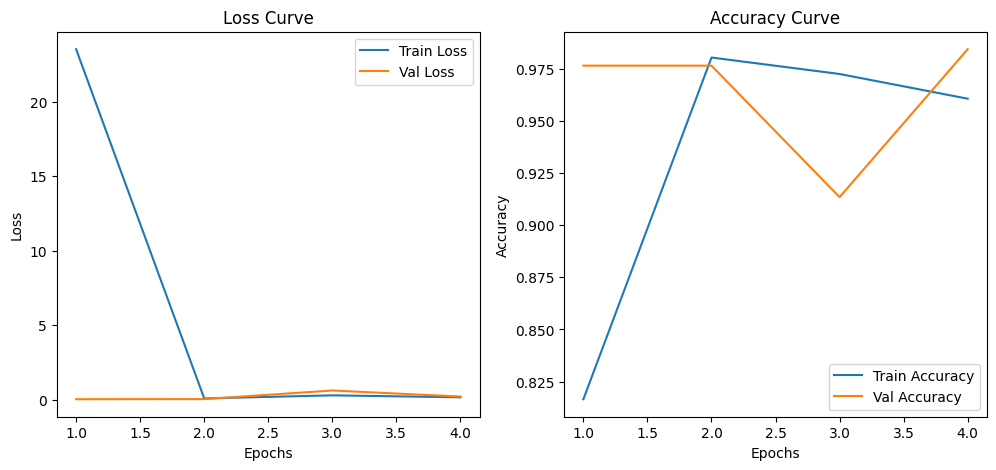

In [ ]:

# STEP 8: Plot Loss & Accuracy
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# STEP 9: Evaluate Model
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9554 - loss: 0.1838

Test Accuracy: 0.9640
Test Loss: 0.1430


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 997ms/step


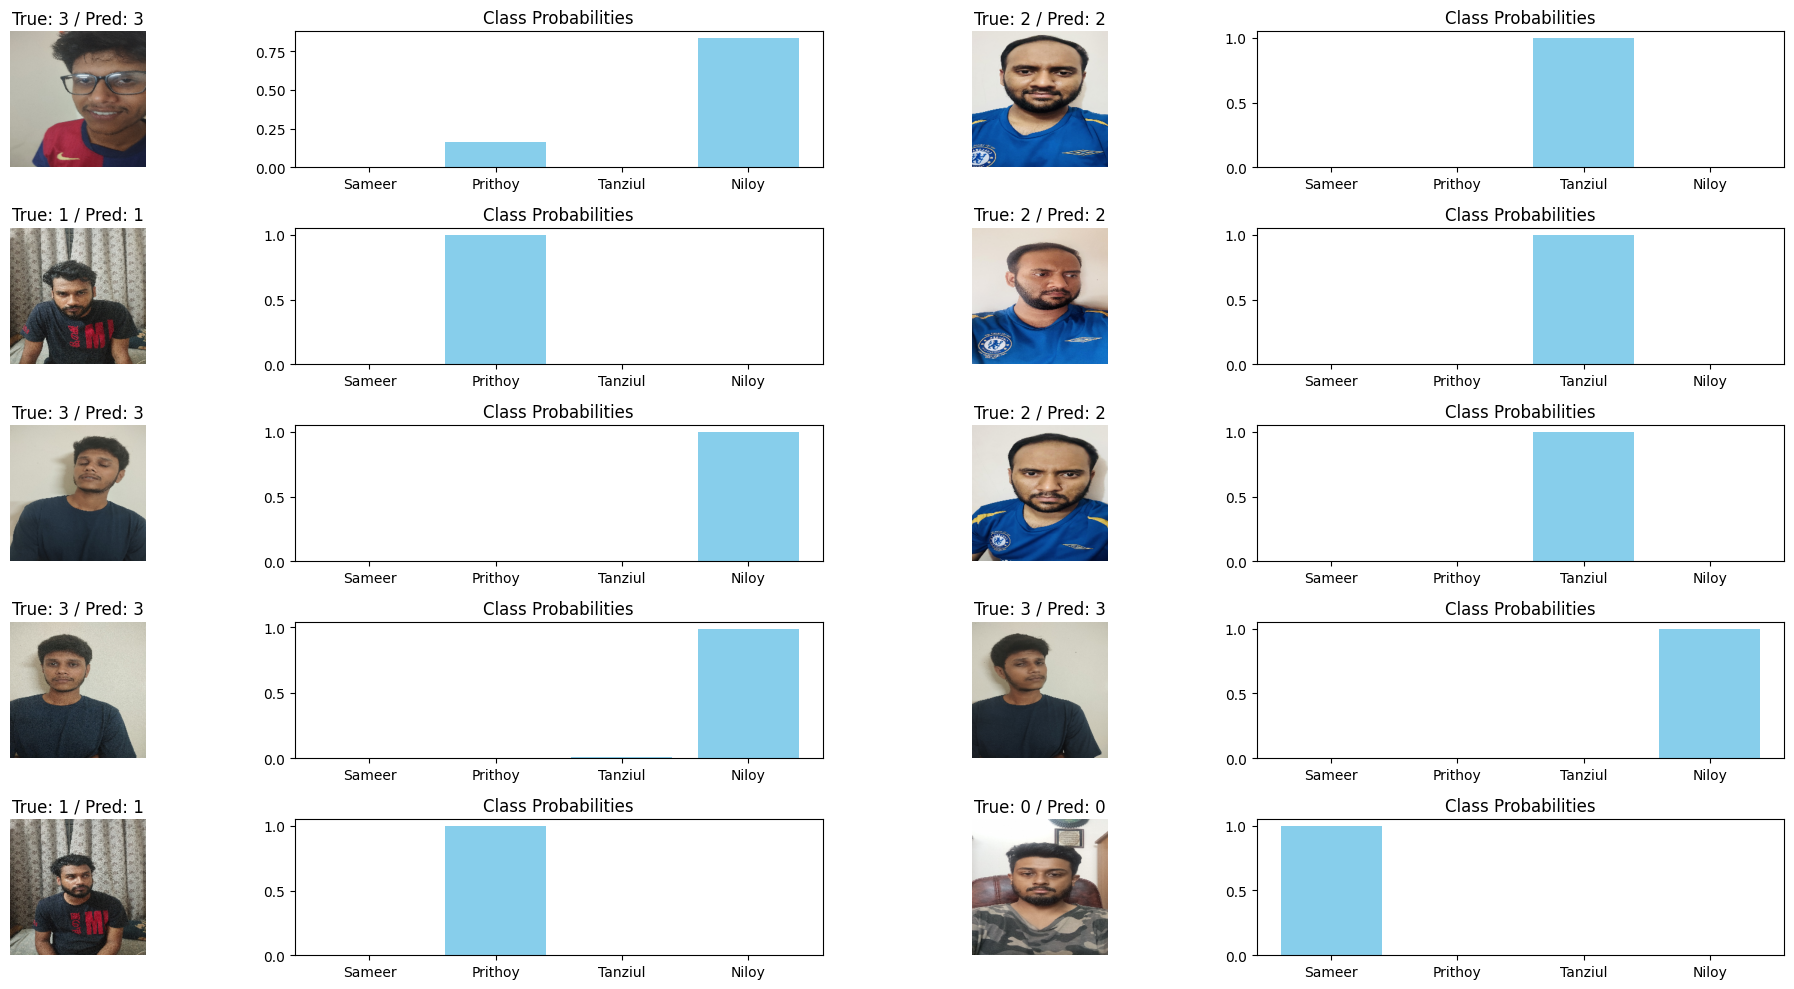

In [ ]:
# STEP 10: Predictions
preds = model.predict(X_test_norm)
label_names = folder_names

plt.figure(figsize=(20, 10))
for i in range(min(10, len(X_test))):
    plt.subplot(5, 4, 2*i+1)
    img_rgb = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"True: {Y_test[i][0]} / Pred: {np.argmax(preds[i])}")
    plt.axis('off')

    plt.subplot(5, 4, 2*i+2)
    plt.bar(range(4), preds[i], color='skyblue')
    plt.xticks(range(4), label_names)
    plt.title("Class Probabilities")
plt.tight_layout()
plt.show()

# STEP 11: Save Model
model.save("/content/drive/MyDrive/model_custom_cnn_face_recognition.h5")